In [2]:
#LSTM regression with time step
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error
import pandas as pd
from sklearn.model_selection import train_test_split


2023-05-17 17:01:45.961723: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-17 17:01:46.554037: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-17 17:01:46.557208: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-17 17:01:48.099330: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
#convert an array of values into a dataset matrix

dataframe = pd.read_csv('../../../datasets/dr-nubel/strain_stress_with_target/full_strain_stress_data.csv')
# df.head(2)

### Split dataset 1

In [21]:

def create_dataset(dataset, look_back=1):
 dataX, dataY = [], []
 for i in range(len(dataset)-look_back-1):
  a = dataset[i:(i+look_back), 0]
  dataX.append(a)
  dataY.append(dataset[i + look_back, 0])
 return numpy.array(dataX), numpy.array(dataY)
#random seed 
numpy.random.seed(7)
#load the dataset
# dataframe = read_csv('sales_year.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')


In [22]:
#normalize the dataset
# scaler = MinMaxScaler(feature_range=(0, 1))
# dataset = scaler.fit_transform(dataset)

#split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,0:3], dataset[train_size:len(dataset),0:3]
ytrain, ytest = dataset[0:train_size,3], dataset[train_size:len(dataset),3]

In [6]:
dataset.shape,train.shape,test.shape,ytrain.shape,ytest.shape

((2365, 4), (1584, 3), (781, 3), (1584,), (781,))

### Split dataset 2

In [23]:
values = dataframe.values
X, y = values[:, 0:3], values[:,3]

In [24]:
train, test, ytrain, ytest = train_test_split(X, y,test_size=0.3,random_state=42)

In [25]:
dataset = numpy.concatenate((ytrain, ytest), axis=0)

In [26]:
dataset.shape,train.shape,test.shape,ytrain.shape,ytest.shape

((2365,), (1655, 3), (710, 3), (1655,), (710,))

### Scale dataset

In [27]:
scalarX, scalarY = StandardScaler(), MinMaxScaler()

train = scalarX.fit_transform(train)
test = scalarX.fit_transform(test)

ytrain = scalarY.fit_transform(ytrain.reshape(-1,1))
ytest = scalarY.fit_transform(ytest.reshape(-1,1))

In [28]:
ytrain.shape

(1655, 1)

In [29]:
#reshape into X=t and Y=t+1
look_back = 1
# trainX, trainY = create_dataset(train, look_back)
# testX, testY = create_dataset(test, look_back)
'''************************************************'''
#reshape input to be [samples, time steps, features]
# trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 3))
# testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 3))
#we are putting back the feature dimension = 1
'''***********************************************'''

trainX = numpy.reshape(train, (train.shape[0], 1, 3))
testX = numpy.reshape(test, (test.shape[0], 1, 3))

# X_reshape = np.reshape(X, (X.shape[0], 1, X.shape[1]))

In [30]:
trainX.shape,testX.shape

((1655, 1, 3), (710, 1, 3))

In [31]:
#create and fit the LSTM network
model = Sequential()
model.add(LSTM(17, input_shape=(look_back, 3)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, ytrain, epochs=10, batch_size=28, verbose=1)


Epoch 1/10


2023-05-17 17:04:28.443391: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-17 17:04:28.445417: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-17 17:04:28.447063: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

60/60 [==============================] - 2s 2ms/step - loss: 0.1741
Epoch 2/10
60/60 [==============================] - 0s 3ms/step - loss: 0.0704
Epoch 3/10
60/60 [==============================] - 0s 3ms/step - loss: 0.0311
Epoch 4/10
60/60 [==============================] - 0s 3ms/step - loss: 0.0249
Epoch 5/10
60/60 [==============================] - 0s 3ms/step - loss: 0.0239
Epoch 6/10
60/60 [==============================] - 0s 3ms/step - loss: 0.0231
Epoch 7/10
60/60 [==============================] - 0s 3ms/step - loss: 0.0222
Epoch 8/10
60/60 [==============================] - 0s 3ms/step - loss: 0.0214
Epoch 9/10
60/60 [==============================] - 0s 3ms/step - loss: 0.0206
Epoch 10/10
60/60 [==============================] - 0s 3ms/step - loss: 0.0199


In [32]:
#make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)


52/52 [==============================] - 0s 2ms/step


2023-05-17 17:04:32.938585: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-17 17:04:32.940331: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-17 17:04:32.941569: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

23/23 [==============================] - 0s 2ms/step


In [33]:
trainPredict.shape,ytrain.shape

((1655, 1), (1655, 1))

In [34]:
# y_train = ytrain.reshape(-1,1)

In [35]:
#invert predictions
trainPredict = scalarY.inverse_transform(trainPredict)
trainY = scalarY.inverse_transform(ytrain)
testPredict = scalarY.inverse_transform(testPredict)
testY = scalarY.inverse_transform(ytest)


In [36]:
trainPredict.shape,trainY.shape,testPredict.shape,testY.shape

((1655, 1), (1655, 1), (710, 1), (710, 1))

In [37]:
#calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[:,0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[:,0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 57.41 RMSE
Test Score: 56.40 RMSE


In [18]:
# numpy.empty_like(dataset[:,3])
# dataset[:,3].reshape(-1,1),trainPredict

### Result for split data 1

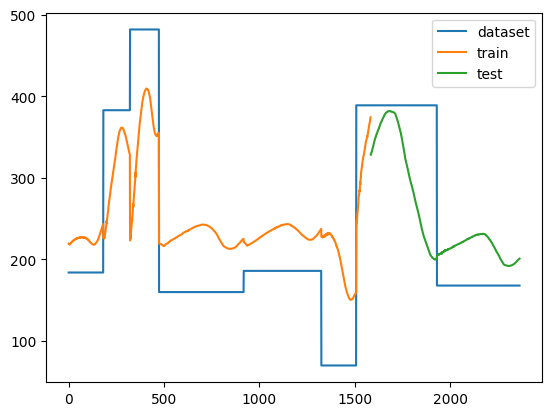

In [20]:
#----------Visualize-------------------------
#shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset[:,3].reshape(-1,1))
trainPredictPlot[:,:] = numpy.nan
# trainPredictPlot[look_back:len(trainPredict)+look_back,:] = trainPredict
trainPredictPlot[:len(trainPredict),:] = trainPredict

#shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset[:,3].reshape(-1,1))
testPredictPlot[:,:] = numpy.nan
testPredictPlot[len(trainPredict):len(dataset)] = testPredict
#plot baseline and predictions
plt.plot(dataset[:,3].reshape(-1,1), label='dataset')
plt.plot(trainPredictPlot,label='train')
plt.plot(testPredictPlot,label='test')
plt.legend()
plt.show()

### Result from split data 2

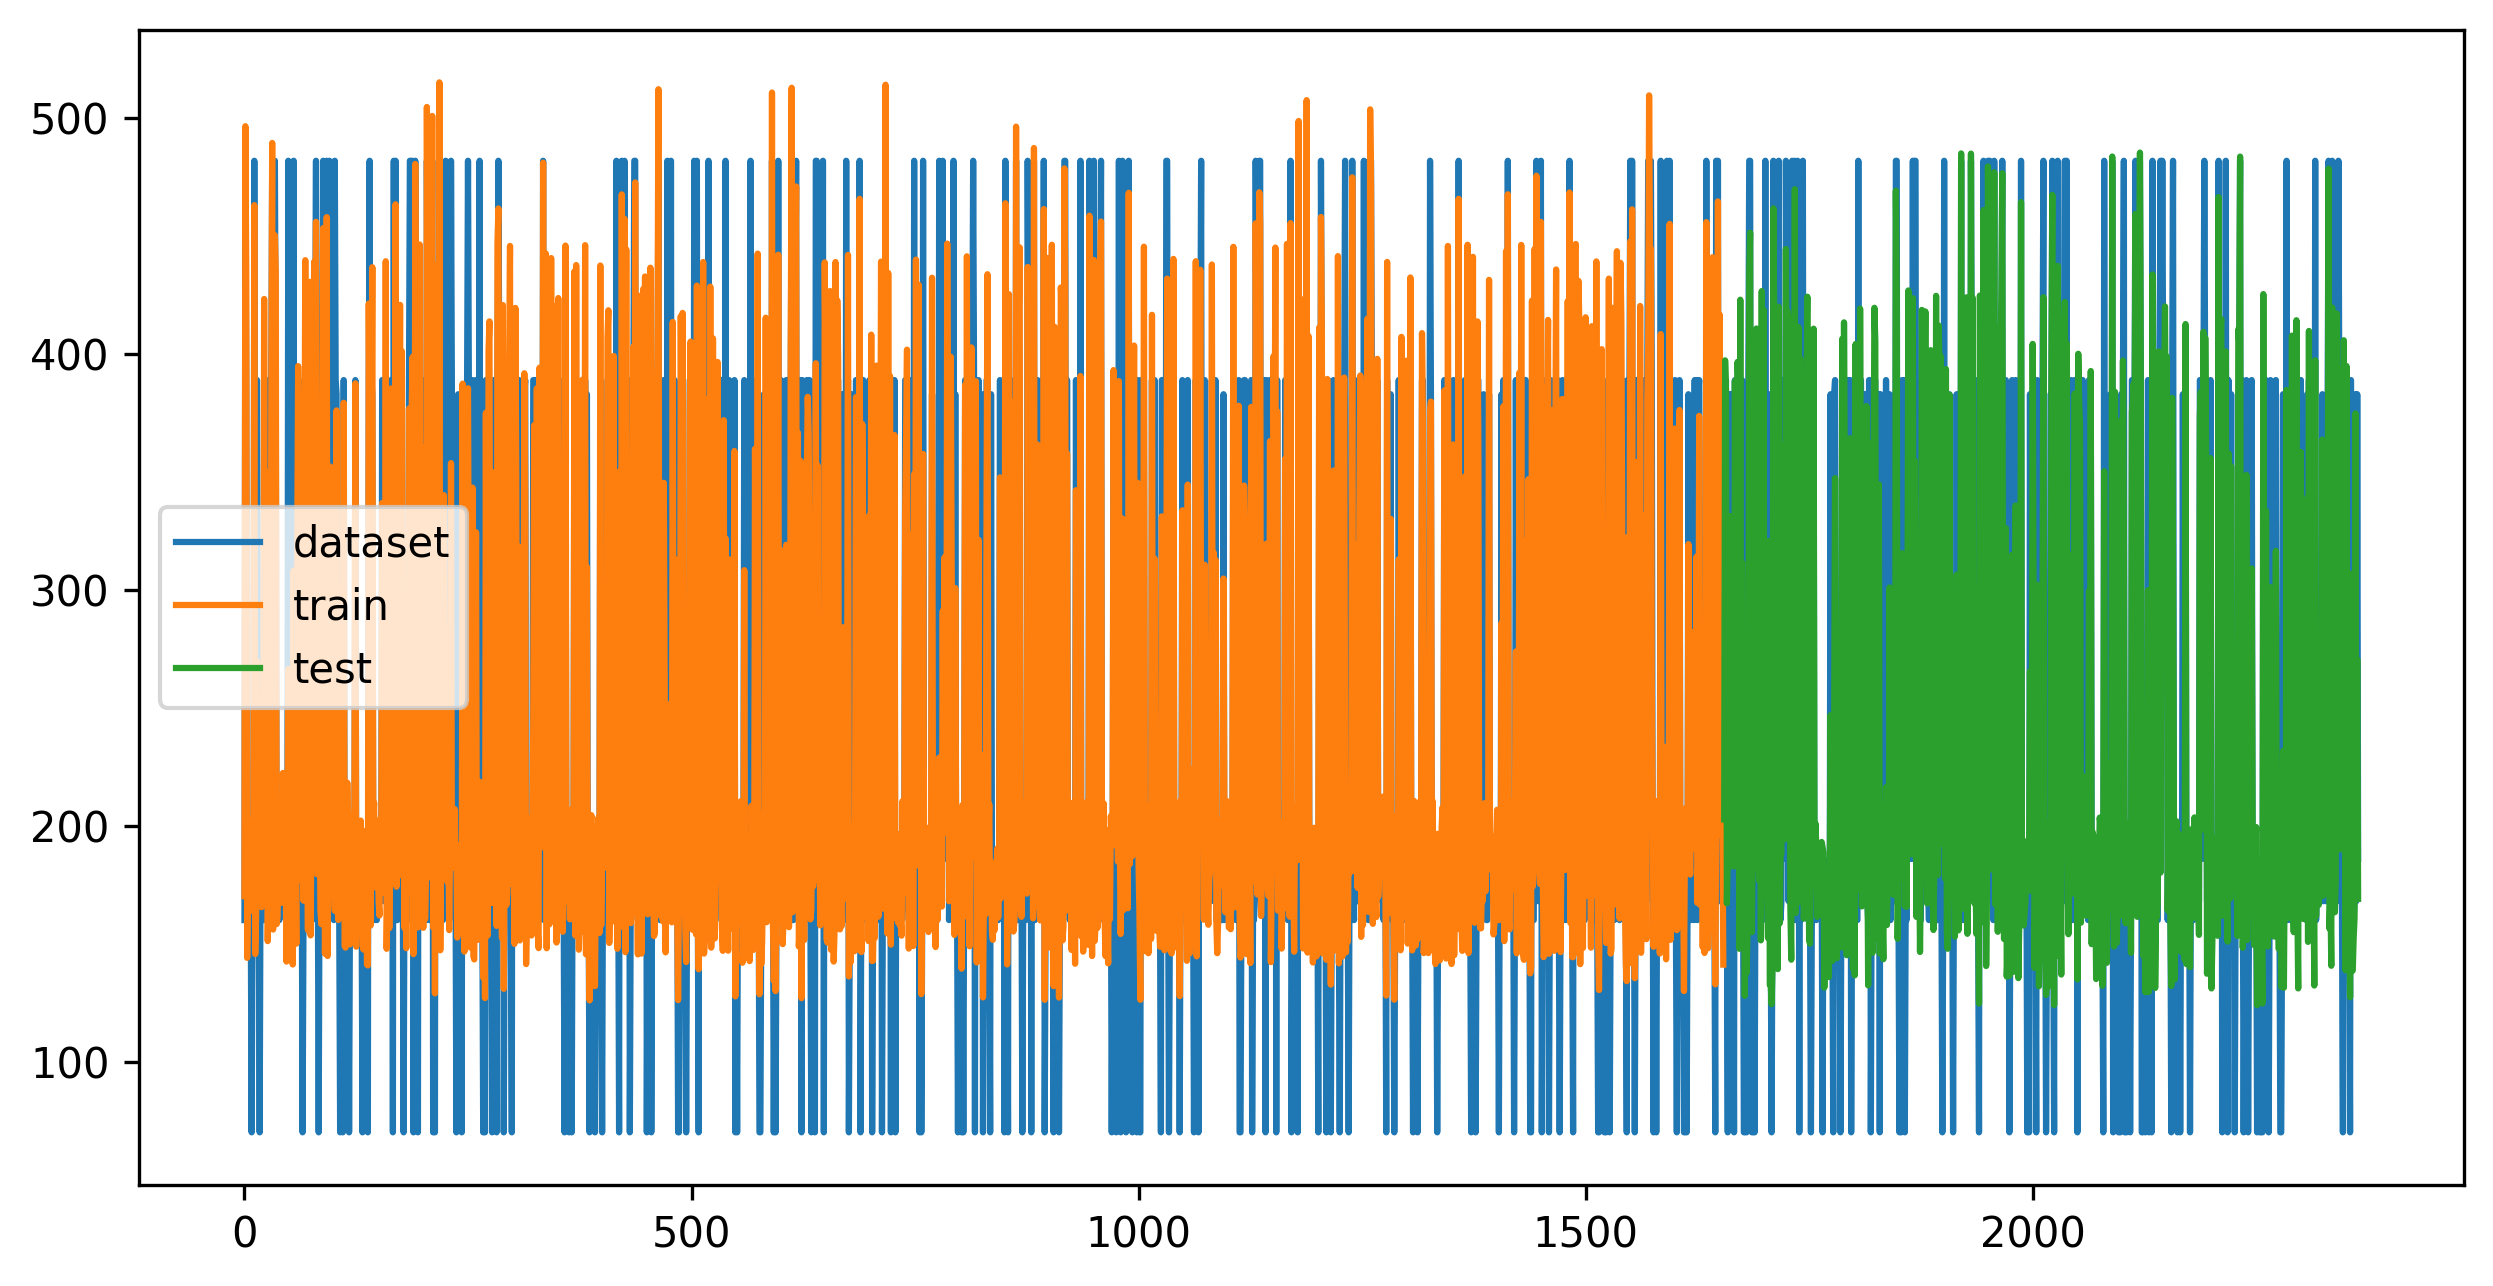

In [42]:
#----------Visualize-------------------------
#shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset.reshape(-1,1))
trainPredictPlot[:,:] = numpy.nan
# trainPredictPlot[look_back:len(trainPredict)+look_back,:] = trainPredict
trainPredictPlot[:len(trainPredict),:] = trainPredict

#shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset.reshape(-1,1))
testPredictPlot[:,:] = numpy.nan
testPredictPlot[len(trainPredict):len(dataset)] = testPredict
#plot baseline and predictions
plt.figure(figsize=(10,5),dpi=300)
plt.plot(dataset.reshape(-1,1), label='dataset')
plt.plot(trainPredictPlot,label='train')
plt.plot(testPredictPlot,label='test')
plt.legend()
plt.show()